In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [2]:
class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule, self).__init__()
        # 定义一个三层卷积
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(128, 3)

    def forward(self, X):
        # 图片先经过三层卷积，输出维度(batch_size,C_out,H,W)
        out = self.conv(X)
        # 使用平均池化层将图片的大小变为1X1
        out = F.avg_pool2d(out, 14)
        # 将张量out从shape batch 128 x 1 x 1 x 1 变成  batch 128
        out = out.squeeze()
        # 输入到全连接层将输出的维度变为3
        out = self.fc(out)
        return out

In [3]:
device = torch.device("cuda")

In [4]:
# 数据增强 镜像操作/直方图均衡化
# car 779 truck 360 bus 218
import os
import cv2 as cv

bus_path = '/home/hatcher/test/deep-learning/VehicleDataset/bus'
car_path = '/home/hatcher/test/deep-learning/VehicleDataset/car'
truck_path = '/home/hatcher/test/deep-learning/VehicleDataset/truck'
bus_pics = os.listdir(bus_path)
car_pics = os.listdir(car_path)
truck_pics = os.listdir(truck_path)
bus_list, car_list, truck_list = [], [], []

for bus_pic in bus_pics:
    img = cv.imread(bus_path+"/"+bus_pic)
    img = cv.resize(img, (32, 32))
    flip_img = cv.flip(img, 1)
    equ_img = cv.equalizeHist(cv.cvtColor(img,cv.COLOR_BGR2GRAY))
    equ_img=cv.cvtColor(equ_img,cv.COLOR_GRAY2BGR)
    img = img/255
    bus_list.append(img)
    flip_img = flip_img/255
    bus_list.append(flip_img)
    equ_img = equ_img/255
    bus_list.append(equ_img)

for car_pic in car_pics:
    img = cv.imread(car_path+"/"+car_pic)
    img = cv.resize(img, (32, 32))
    img = img/255
    car_list.append(img)

for truck_pic in truck_pics:
    img = cv.imread(truck_path+"/"+truck_pic)
    img = cv.resize(img, (32, 32))
    flip_img = cv.flip(img, 1)
    img = img/255
    truck_list.append(img)
    flip_img = flip_img/255
    truck_list.append(flip_img)

In [5]:
bus_length = len(bus_list)
car_length = len(car_list)
truck_length = len(truck_list)
num_bus_train = int(len(bus_list)*0.8)
num_car_train = int(len(car_list)*0.8)
num_truck_train = int(len(truck_list)*0.8)
train_y,test_y=[],[]
for i in range(num_bus_train):
    #train_y.append([1,0,0,0,0,0,0,0,0,0])
    train_y.append([1,0,0])
for i in range(num_car_train):
    #train_y.append([0,1,0,0,0,0,0,0,0,0])
    train_y.append([0,1,0])
for i in range(num_truck_train):
    #train_y.append([0,0,1,0,0,0,0,0,0,0])
    train_y.append([0,0,1])
for i in range(num_bus_train,bus_length):
    #test_y.append([1,0,0,0,0,0,0,0,0,0])
    test_y.append([1,0,0])
for i in range(num_car_train,car_length):
    #test_y.append([0,1,0,0,0,0,0,0,0,0])
    test_y.append([0,1,0])
for i in range(num_truck_train,truck_length):
    #test_y.append([0,0,1,0,0,0,0,0,0,0])
    test_y.append([0,0,1])
train_x,test_x=[],[]
for i in range(num_bus_train):
    train_x.append(bus_list[i])
for i in range(num_car_train):
    train_x.append(car_list[i])
for i in range(num_truck_train):
    train_x.append(truck_list[i])
for i in range(num_bus_train,bus_length):
    test_x.append(bus_list[i])
for i in range(num_car_train,car_length):
    test_x.append(car_list[i])
for i in range(num_truck_train,truck_length):
    test_x.append(truck_list[i])

train_x = torch.Tensor(train_x).permute(0,3,1,2)
test_x = torch.Tensor(test_x).permute(0,3,1,2)
train_y = torch.Tensor(train_y)
test_y = torch.Tensor(test_y)
print("train_x:",train_x.size())
print("test_x:",test_x.size())
print("train_y:",train_y.size())
print("test_y:",test_y.size())


/tmp/ipykernel_70226/1321487925.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_x = torch.Tensor(train_x).permute(0,3,1,2)


train_x: torch.Size([1722, 3, 32, 32])
test_x: torch.Size([431, 3, 32, 32])
train_y: torch.Size([1722, 3])
test_y: torch.Size([431, 3])


In [6]:
train_x = train_x[1:1701,:,:,:]
test_x = test_x[1:431,:,:,:]
train_y = train_y[1:1701,:]
test_y = test_y[1:431,:]
print("train_x:",train_x.size())
print("test_x:",test_x.size())
print("train_y:",train_y.size())
print("test_y:",test_y.size())

train_x: torch.Size([1700, 3, 32, 32])
test_x: torch.Size([430, 3, 32, 32])
train_y: torch.Size([1700, 3])
test_y: torch.Size([430, 3])


In [15]:
import torch.utils.data as Data
batch_size = 20# 将训练数据的特征和标签组合
train_dataset,test_dataset = Data.TensorDataset(train_x, train_y),Data.TensorDataset(test_x, test_y)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
test_iter = Data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True,num_workers=2)

In [8]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        #y_hat = y_hat.view(1,-1) 
        acc_sum += (y_hat.argmax(dim=1) == y.argmax(dim=1)).sum().item()
        l = loss(y_hat, y).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

In [9]:
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    train_loss=[]
    test_loss=[]
    train_accuracy=[]
    test_accuracy=[]
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            y = y.to(device)
            #print(y.size())
            y_hat = net(X)
            y_hat = y_hat.squeeze()
            #y_hat = y_hat.view(1,-1) 
            #print(y_hat.size())
            l=loss(y_hat,y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            train_l_sum+=l.item()
            '''print(y_hat.shape)
            print(y.shape)
            print(y_hat)
            print(y_hat.argmax(dim=1))
            print(y)
            print(y_hat.argmax(dim=1)==y)
            '''
            train_acc_sum+=(y_hat.argmax(dim=1)==y.argmax(dim=1)).sum().item()
            n+=y.shape[0]
        test_acc,test_l = evaluate_accuracy(test_iter,net,loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
        train_accuracy.append(train_acc_sum/n)
        test_accuracy.append(test_acc)
        print('epoch%d,loss%.4f,train acc %3f,test acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))
    return train_loss,test_loss,train_accuracy,test_accuracy

In [10]:
num_epochs=50
lr=0.1
loss=nn.CrossEntropyLoss()

In [16]:
net = ConvModule()
net.to(device)
optimizer=torch.optim.SGD(net.parameters(),lr)
for params in net.parameters():
    nn.init.normal_(params,mean=0,std=0.01)

In [17]:
train_loss,test_loss,train_accuracy,test_accuracy=train(net,train_iter,test_iter,loss,num_epochs,batch_size,net.parameters(),lr,optimizer)

epoch1,loss0.0549,train acc 0.364118,test acc 0.363
epoch2,loss0.0537,train acc 0.418235,test acc 0.498
epoch3,loss0.0454,train acc 0.576471,test acc 0.665
epoch4,loss0.0337,train acc 0.745294,test acc 0.793
epoch5,loss0.0241,train acc 0.833529,test acc 0.795
epoch6,loss0.0190,train acc 0.864706,test acc 0.730
epoch7,loss0.0169,train acc 0.881176,test acc 0.879
epoch8,loss0.0146,train acc 0.898824,test acc 0.874
epoch9,loss0.0142,train acc 0.904706,test acc 0.884
epoch10,loss0.0123,train acc 0.914118,test acc 0.863
epoch11,loss0.0115,train acc 0.910588,test acc 0.902
epoch12,loss0.0095,train acc 0.928824,test acc 0.919
epoch13,loss0.0093,train acc 0.931176,test acc 0.909
epoch14,loss0.0083,train acc 0.941176,test acc 0.877
epoch15,loss0.0083,train acc 0.932941,test acc 0.912
epoch16,loss0.0072,train acc 0.950000,test acc 0.937
epoch17,loss0.0067,train acc 0.954118,test acc 0.937
epoch18,loss0.0072,train acc 0.945294,test acc 0.942
epoch19,loss0.0060,train acc 0.958235,test acc 0.930
ep

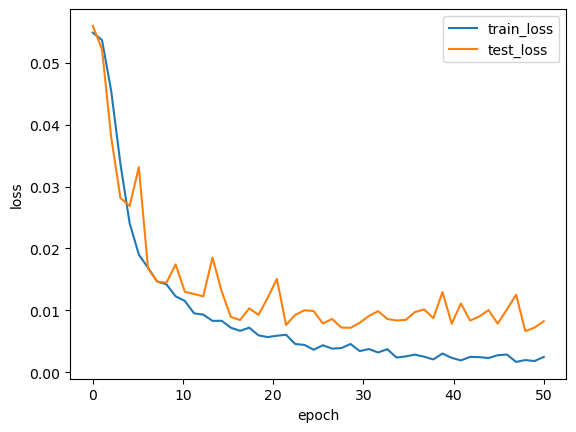

In [18]:
import matplotlib.pyplot as plt
import numpy as np
x=np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label='train_loss',linewidth=1.5)
plt.plot(x,test_loss,label='test_loss',linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

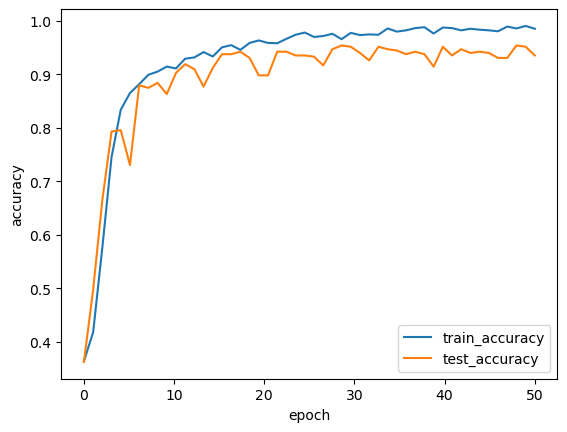

In [19]:
x=np.linspace(0,len(train_accuracy),len(train_accuracy))
plt.plot(x,train_accuracy,label='train_accuracy',linewidth=1.5)
plt.plot(x,test_accuracy,label='test_accuracy',linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()